# TIF345/FYM345: Project 3: A Galton board on a rocking ship

# Names 
Jonatan Haraldsson [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

Jesper Noord [noord@chalmers.se](mailto:noord@chalmers.se)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import sklearn
import pandas as pd
import emcee
import numpy as np
import random
import tqdm
from tqdm import trange
import keras as keras
import tensorflow as tf

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

sns.set_palette('deep')
from matplotlib import cbook, cm
from seaborn import cm
from matplotlib.colors import LightSource
# plot in separate window
%matplotlib inline

rng = np.random.default_rng(seed = 42)

### Importing and massaging data

In [20]:
board_data = np.load('board_data.npy')

board_df = pd.DataFrame(board_data, columns = [f'bin_{i}' for i in range(32)])

display(board_df)


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,bin_31
0,0.0,0.0,0.0,2.0,5.0,9.0,11.0,28.0,31.0,47.0,...,8.0,8.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,...,78.0,59.0,57.0,34.0,26.0,7.0,6.0,2.0,1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,8.0,19.0,18.0,27.0,47.0,...,11.0,5.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,13.0,57.0,79.0,85.0,116.0,109.0,119.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,88.0,54.0,70.0,28.0,25.0,14.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,76.0,75.0,54.0,36.0,26.0,11.0,2.0,3.0,0.0,0.0
9996,2.0,47.0,60.0,107.0,113.0,109.0,121.0,117.0,100.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9.0,29.0,63.0,81.0,115.0,121.0,131.0,112.0,99.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,99.0,87.0,85.0,84.0,48.0,30.0,12.0,3.0,0.0


### Plots

Referring to the classical case with a Galton board, where the bead has an equal probability of bouncing to the left or the right, the distribution will converge to a binomial distribution for $N_\text{samples} \rightarrow\infty$.

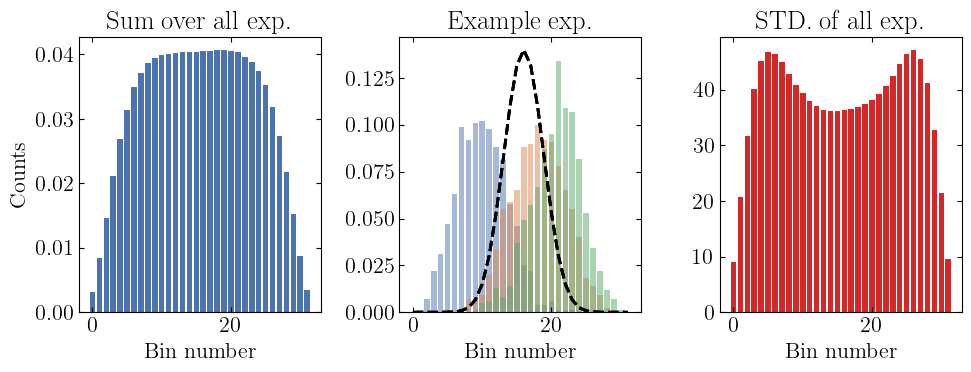

In [21]:

fig, ax = plt.subplots(1,3,figsize = (10, 4))

ax[0].bar(np.arange(32), board_data.sum(axis=0) / board_data.sum())
ax[0].set_xlabel('Bin number')
ax[0].set_ylabel('Counts')


for n in range(3):
    i = rng.integers(0, board_data.shape[0])
    ax[1].bar(np.arange(32), board_data[i]/ board_data[i].sum(),alpha=0.5)
    ax[1].plot(scipy.stats.binom.pmf(np.arange(32), n=32, p=1/2), color='black', lw=2,ls = '--')

ax[1].set_xlabel('Bin number')
ax[1].set_title('Example exp.')
ax[0].set_title('Sum over all exp.')
ax[2].set_title('STD. of all exp.')
ax[2].bar(np.arange(32), np.std(board_data,axis=0),color='tab:red')
ax[2].set_xlabel('Bin number')
plt.tight_layout()

plt.show()

In [279]:
def p_peg(alpha,s,left=None):
    if left == None:
        M = 0.
    elif left:
        M = 0.5
    else:
        M = -0.5
    return 0.5 + (alpha * M + s)
    
def simulator(alpha,s, N=int(1e3)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(32)
    for j in range(int(N)):
        left_bounces = 0
        left = 0
        left_ = 0
        for i in range(31):
            r = rng.uniform(0,1)
            if i == 0:
                left_ = r < p_peg(alpha,s,left=None)
                #print(f'{p_peg(alpha,s,left=None)} and r = {r} gives left = {left_}')
            else:
                left_ = r < p_peg(alpha,s,left=left)
            if left_:
                left_bounces += 1
            else:
                pass
            left = left_
        bin_counts[left_bounces] += 1
        left_bounces = 0
    return bin_counts 

def simulator2(alpha,s, N=int(1e3)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(N)
    for j in range(int(N)):
        left_bounces = 0
        left = 0
        left_ = 0
        for i in range(31):
                r = rng.uniform(0,1)
                if i == 0:
                    left_ = r < p_peg(alpha,s,left=None)
                    #print(f'{p_peg(alpha,s,left=None)} and r = {r} gives left = {left_}')
                else:
                    left_ = r < p_peg(alpha,s,left=left)
                if left_:
                    left_bounces += 1
                else:
                    pass
                left = left_
        bin_counts[j] = 31 - left_bounces
    return bin_counts


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]
15.4238 22.739993559999995


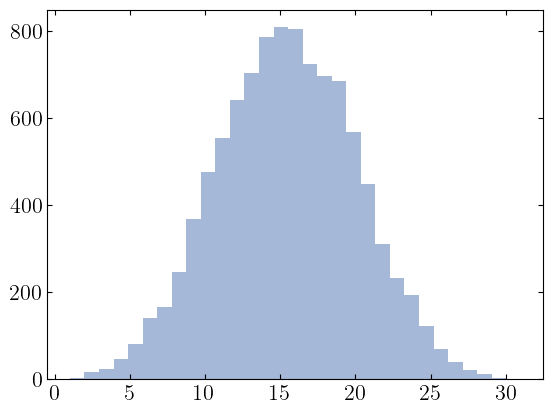

In [23]:
alpha = 0.5
s = .0

counts = simulator2(alpha,s, N=int(1e4))

print(np.unique(counts))
print(np.mean(counts), np.std(counts)**2)

plt.hist(counts, bins = len(np.unique(counts)), alpha=0.5, label='Simulated data')
plt.show()


467.7209370981804
16
0.4257


<BarContainer object of 32 artists>

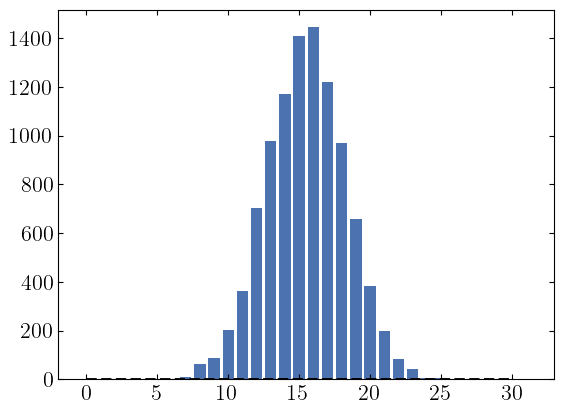

In [278]:
alpha = 0.0
s = .0
res = simulator(alpha,s)

print(res.std())
ind = np.argmax(res)
print(ind)
print(np.sum((res[ind],res[int(ind-1)],res[int(ind-1)])) / np.sum(res))

plt.plot(scipy.stats.binom.pmf(np.arange(31), n=31, p=p_peg(alpha,s)), color='black', lw=2,ls = '--')

plt.bar(np.arange(32), res) 

In [ ]:
def statistic(data):
    x = np.arange(len(data))
    data = data / np.sum(data)
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, np.sqrt(var)

In [26]:
alphas = np.linspace(0,0.5,11)
ss = np.linspace(-0.25,0.25,11)
means = np.zeros((len(alphas), len(ss)))
variances = np.zeros((len(alphas), len(ss)))
for i, alpha in enumerate(alphas):
    for j, s in enumerate(ss):
        res = simulator(alpha,s)
        mean, var = statistic(res)
        means[i,j] = mean
        variances[i,j] = var

In [27]:
def grid_gen(xlim, ylim, size=50):
    x = np.linspace(xlim[0], xlim[1], size)
    y = np.linspace(ylim[0], ylim[1], size)
    X, Y = np.meshgrid(x, y)
    return X, Y


def contour_generator(xlim, ylim, size=50):
    X, Y = grid_gen(xlim, ylim, size)
    Z1 = np.zeros_like(X)
    Z2 = np.zeros_like(X)

    for i in trange(X.shape[0]):
        for j in range(X.shape[1]):
            res = simulator(X[i, j], Y[i, j])
            mean, var = statistic(res)
            Z1[i, j] = mean
            Z2[i, j] = var
    return X, Y, Z1, Z2

In [28]:
#A,S,MEAN,STD = contour_generator((0,0.5),(-0.25,0.25),size=25)

In [29]:
# fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True) 
# conf0 = ax[0].contourf(S,A , MEAN/ np.max(MEAN), levels=100, cmap='coolwarm')
# #ax[0].contour(A, S, Z, levels=100, c='k',alpha =0.5)
# conf1 = ax[1].contourf(S, A, STD / np.max(STD) , levels=100, cmap='Reds')
# ax[0].set_title('Expected value')
# ax[1].set_title('Variance')
# ax[0].set_ylabel(r'$\alpha$')
# ax[0].set_xlabel(r'$s$')
# ax[1].set_xlabel(r'$s$')

# fig.colorbar(conf0, ax=ax[0],label='Exp')
# fig.colorbar(conf1, ax=ax[1],label='Std. dev')#'$\\mathbb{COV}$ [eV$^2$]')

# plt.savefig('contour_plots.pdf', bbox_inches='tight')

# conts_mean = np.where(np.abs(Z - 10) < 0.2)
# conts_std = np.where(np.abs(STD/ np.max(STD) - 0.4) < 0.005)

# #A[conts], S[conts]

# ax[0].plot(S[conts_mean],A[conts_mean])
# ax[1].plot(S[conts_std],A[conts_std])


In [30]:
# conts = np.where(np.abs(Z - 10) < 0.1)
# #A[conts], S[conts]

# plt.scatter(S[conts],A[conts])

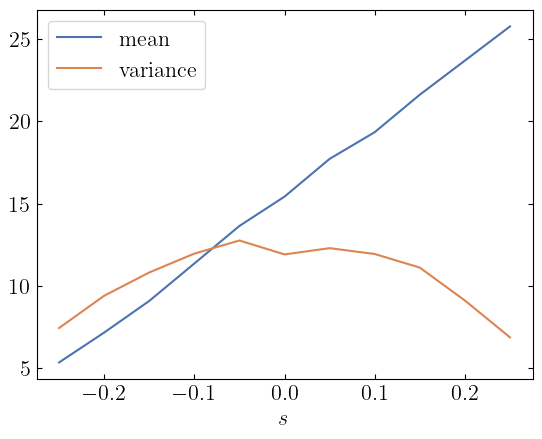

In [31]:
plt.plot(ss, means[5,:],label=f'mean')
plt.plot(ss, variances[5,:],label=f'variance')

plt.xlabel('$s$')
plt.legend()

In [32]:
def generate_data(N_samples):
    train_data = np.zeros((N_samples,32))
    target_data = np.zeros((N_samples,2))
    for n in trange(N_samples):
        s = np.random.uniform(-0.25,0.25)
        a = np.random.uniform(0,0.5)
        a = 0.0
        train_data[n,:] = simulator(a,s)
        target_data[n,0] = a
        target_data[n,1] = s
    return train_data, target_data
    

def generate_data_mesh(N_samples):
    train_data = np.zeros((N_samples**2,32))
    target_data = np.zeros((N_samples**2,2))
    s = np.random.uniform(-0.25,0.25,N_samples)
    a = np.random.uniform(0,0.5,N_samples)
    A,S = np.meshgrid(a,s)
    A = A.ravel()
    S = S.ravel()
    for n in trange(N_samples**2):
        train_data[n,:] = simulator(A[n],S[n])
        target_data[n,0] = A[n]
        target_data[n,1] = S[n]
    return train_data, target_data


#train_data, target_data = generate_data_mesh(50)
#np.save('train_data_mesh.npy', train_data)
#np.save('target_data_mesh.npy', target_data)

In [ ]:
data = np.load('train_data.npy')
target = np.load('target_data.npy')

In [34]:
def kernel(y_pred, y_obs):
    sq = []
    D = []
    h = 5
    for i in range(len(y_pred)):
        diff = (statistic(y_pred[i,:].ravel())[0] - statistic(y_obs.ravel())[0]) / h
        sq.append(diff**2)
        D.append(diff)
    SQ = np.array(sq)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))

In [294]:
def shaper(X):
    return X.reshape(int(np.sqrt(len(X))),int(np.sqrt(len(X))))

def kernel_pred(y_obs,N=100,h=1, mode = None):
    sq = []
    D = []
    #s = np.random.uniform(-0.25,0.25,int(np.sqrt(N)))
    #a = np.random.uniform(0,0.5,int(np.sqrt(N)))
    a = np.linspace(0,0.5,int(np.sqrt(N)))
    s = np.linspace(-0.25,0.25,int(np.sqrt(N)))
    A,S = np.meshgrid(a,s)
    A = A.ravel()
    S = S.ravel()
    h_std = h/4
    for i in trange((N)):
        if mode == 'mean':
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[0] - statistic(y_obs.ravel())[0]
            diff = diff**2 / h
            D.append(diff)
        elif mode == 'std':   
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[1] - statistic(y_obs.ravel())[1]
            diff = diff**2 / h_std
            D.append(diff)
        elif mode == 'both':
            diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
            diff = np.sqrt(diff_mean**2/h**2 + diff_std**2 / h_std**2)
            D.append(diff)
        else:
            raise ValueError("Mode must be 'mean', 'std', or 'both'")
        sq.append(diff)
        
    SQ = np.array(sq)
    D = np.array(D)
    return shaper(D), shaper(np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))), shaper(A),shaper(S)

In [39]:
def joint_plot(x,y,x_name,y_name):
    d = pd.DataFrame(np.vstack((x,y)).T,columns=[f'{x_name}',f'{y_name}'])
    #sns.jointplot(data=d, x=x_name, y=y_name, kind='kde', fill=True, cmap='Blues')
    g = sns.jointplot(data = d, x =x_name,y =y_name,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
    for coll in list(g.ax_joint.collections):
        coll.remove()
    g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
    g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

In [295]:
t_obs = np.array([0.3,0.2])
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

D,P,A,S = kernel_pred(y_obs,N=50*50,h=0.2,mode = 'both')   # Difference in summary statistics  # Kernel size / Probability

Observed parameters: alpha = 0.3, s = 0.2


100%|██████████| 2500/2500 [01:32<00:00, 27.11it/s]


29 44
Observed parameters: alpha = 0.3, s = 0.2


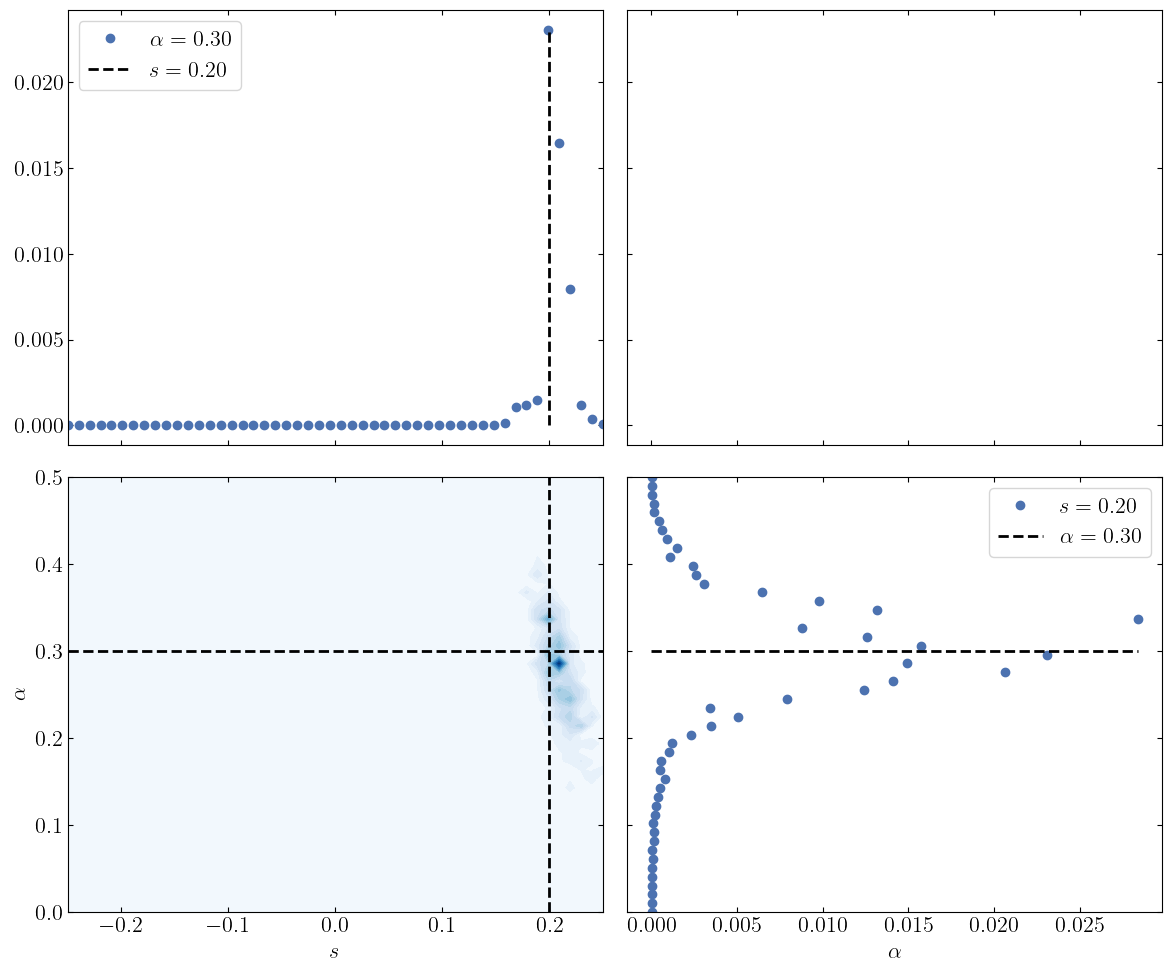

In [296]:


fig, ax = plt.subplots(2,2,figsize=(12,10),sharex='col', sharey='row')
ind_S = np.argmin(abs(A[0,:] - t_obs[0]))
ind_A = np.argmin(abs(S[:,0] - t_obs[1]))

print(ind_S,ind_A)
ax[0,0].plot(S[:,ind_S],P[:,ind_S],'o',label=f'$\\alpha = {A[0,ind_S]:.2f}$')
ax[1,1].plot(P[ind_A,:],A[ind_A,:],'o',label=f'$s= {S[ind_A,0]:.2f}$')
ax[1,1].set_xlabel('$\\alpha$')
ax[1,1].hlines(t_obs[0], 0, np.max(P[ind_A,:]), color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
ax[0,0].vlines(t_obs[1], 0.0, np.max(P[:,ind_S]), color='black', lw=2, ls='--',label=f'$s = {t_obs[1]:.2f}$')
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

ax[0,0].legend()
ax[1,1].legend()

ax[1,0].contourf(S,A,P, levels=20, cmap='Blues')
ax[1,0].vlines(t_obs[1], -0.0, 0.5, color='black', lw=2, ls='--',label=f'$s = {t_obs[1]:.2f}$')
ax[1,0].hlines(t_obs[0], -0.25, 0.25, color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')
plt.tight_layout()

## Neural Network

In [216]:
data = np.load('train_data.npy')
target = np.load('target_data.npy')

In [217]:
fraction_train = 0.70; fraction_test = 0.10; fraction_valid = 1. - fraction_train - fraction_test

data_train = data[:int(fraction_train*len(data))]
target_train = target[:int(fraction_train*len(target))]

data_test = data[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(data))+1]
target_test = target[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(target))+1]

data_valid = data[1+int((fraction_train+fraction_test)*len(data)):]
target_valid = target[1+int((fraction_train+fraction_test)*len(target)):]

print(f"Training and target data size: {len(data_train)} x {len(target_train)} ")
print(f"Testing and target data size: {len(data_test)} x {len(target_test)} ")
print(f"Validation and target data size: {len(data_valid)} x {len(target_valid)} ")

Training and target data size: 7000 x 7000 
Testing and target data size: 1000 x 1000 
Validation and target data size: 2000 x 2000 


In [218]:
model = keras.models.Sequential([   
    keras.layers.Dense(64, activation='tanh', input_shape=(32,)),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(2,activation='tanh')
])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,258 (16.63 KB)

 Trainable params: 4,258 (16.63 KB)

 Non-trainable params: 0 (0.00 B)

In [219]:
model.compile(
  optimizer='adam',
  loss='mse',metrics=['accuracy'])

In [220]:
epochs = 150     ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  data_train, target_train,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 0,
  validation_data=(data_valid, target_valid))

In [221]:
predictions = model.predict(data_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


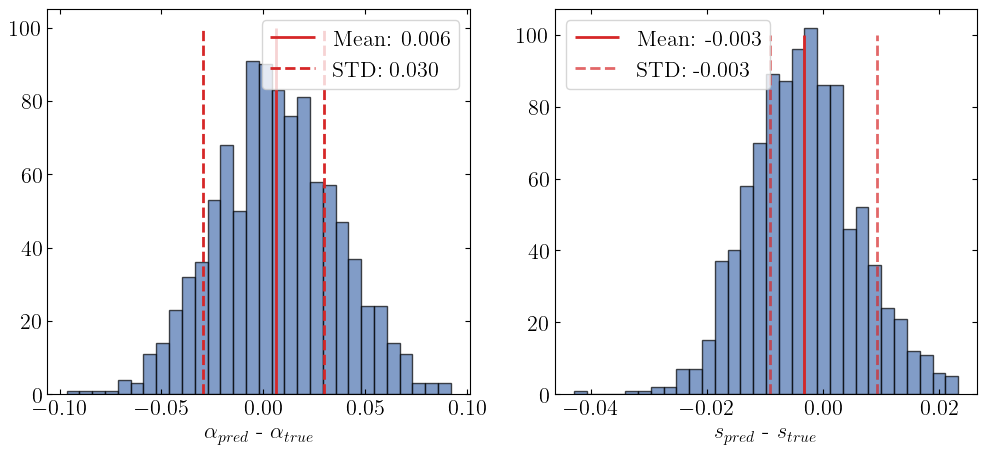

In [222]:
dif = predictions[:,0] - target_test[:,0]
dif1 = predictions[:,1] - target_test[:,1]

fig, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].hist(predictions[:,0] - target_test[:,0],bins = 30 ,edgecolor='black', alpha=0.7)
ax[0].vlines(np.mean(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: {np.mean(dif):.3f}')
ax[0].vlines(np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--', label = f'STD: {np.std(dif):.3f}')
ax[0].vlines(-np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--')
ax[0].set_xlabel('$\\alpha_{pred}$ - $\\alpha_{true}$')


ax[1].hist(predictions[:,1] - target_test[:,1],bins = 30,edgecolor='black', alpha=0.7)
ax[1].vlines(np.mean(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: {np.mean(predictions[:,1] - target_test[:,1]):.3f}')
ax[1].vlines(np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7, label = f'STD: {np.mean(predictions[:,1] - target_test[:,1]):.3f}')
ax[1].vlines(-np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7)
ax[1].set_xlabel('$s_{pred}$ - $s_{true}$')
ax[0].legend()
ax[1].legend()



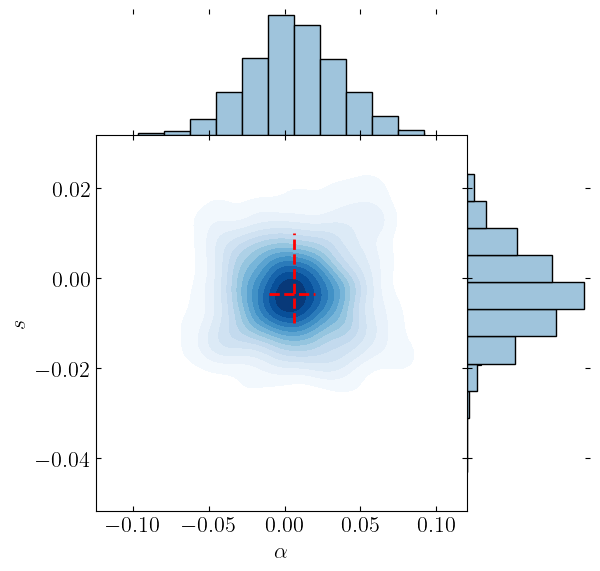

In [223]:

data = pd.DataFrame(np.vstack((dif,dif1)).T,columns=[r"$\alpha$",r'$s$'])
x = r'$\alpha$'; y = '$s$'
#sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'kde',fill = True,cmap='Blues', levels = 15)#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
g = sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
for coll in list(g.ax_joint.collections):
    coll.remove()
g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

plt.vlines(np.mean(dif), -0.01, 0.01, color='red', lw=2, ls='--')
plt.hlines(np.mean(dif1), -0.01, 0.02, color='red', lw=2, ls='--')
#plt.vlines(0.5, -0.25, 0.25, color='red', lw=2, ls='--')
#plt.hlines(-0.25, 0, 0.5, color='red', lw=2, ls='--')
#plt.hlines(0.25, 0, 0.5, color='red', lw=2, ls='--')
plt.show()

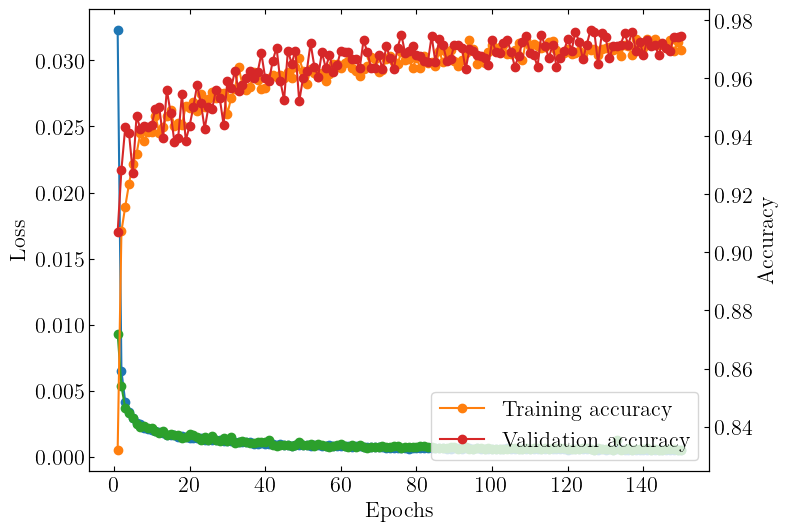

In [224]:
epochrange = range(1, epochs + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#plt.plot(epochrange, train_acc, 'bo', label='Training acc')
#plt.plot(epochrange, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy (modell 1)')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
fig, ax = plt.subplots(figsize=(8, 6))

ax1 = ax.twinx()
ax.plot(epochrange, train_loss, '-o',color = 'tab:blue', label='Training loss')
ax.plot(epochrange, val_loss, '-o',color = 'tab:green', label='Validation loss')
ax1.plot(epochrange, accuracy, '-o',color = 'tab:orange', label='Training accuracy')
ax1.plot(epochrange, val_accuracy, '-o',color = 'tab:red', label='Validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')   
ax1.set_ylabel('Accuracy')   
plt.legend()
plt.show()

In [272]:
preds = model.predict(np.array([y_obs]))
print(f'Predicted parameters: alpha = {preds[0,0]}, s = {preds[0,1]}')  
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted parameters: alpha = 0.2968197762966156, s = 0.2020253688097
Observed parameters: alpha = 0.3, s = 0.2


## ABC NN


In [ ]:
def colonel_NN(model, y_obs, N=100, h=1, mode=None):
    sq = []
    D = []
    a = np.random.uniform(0,0.5,int(N))
    s = model.predict(np.array([y_obs]))[0,1]
    for i in trange((N)):
        if mode == 'mean':
            diff = statistic(simulator(alpha =a[i], s =s).ravel())[0] - statistic(y_obs.ravel())[0]
        elif mode == 'std':   
            diff = statistic(simulator(alpha =a[i], s =s).ravel())[1] - statistic(y_obs.ravel())[1]
        elif mode == 'both':
            diff_mean, diff_std= np.array(statistic(simulator(alpha =a[i], s =s).ravel())) - np.array(statistic(y_obs.ravel()))
            diff = np.sqrt(diff_mean**2 + diff_std**2)
        else:
            raise ValueError("Mode must be 'mean', 'std', or 'both'")
        sq.append(diff**2 / h)
        D.append(diff)
    SQ = np.array(sq)
    D = np.array(D)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ))),a,s

In [ ]:
D_NN,P_NN,a_nn,s_nn = colonel_NN(model, y_obs,N=1000,h=0.11,mode = 'mean')   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.20202537


100%|██████████| 1000/1000 [00:39<00:00, 25.24it/s]


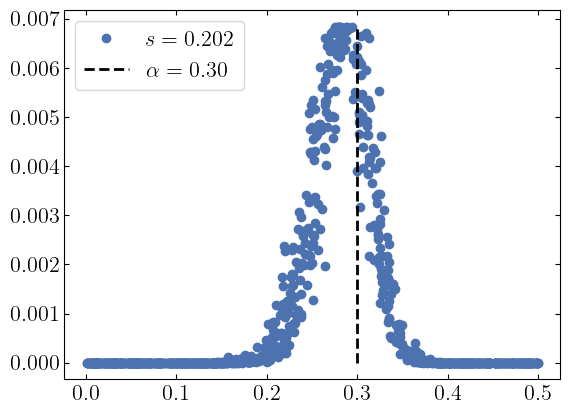

In [271]:
plt.plot(a_nn,P_NN,'o',label=f'$s = {s_nn:.3f}$')
plt.vlines(t_obs[0], 0, np.max(P_NN), color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
plt.legend()

## Chain of posterior

In [ ]:

def statistic_2(data,x):
    data = data / np.sum(data)
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, np.sqrt(var)



def kernel_chain(y_obs,N=500,N_chain = 5, h=1, mode=None):
    for j in range(N_chain):
        sq = []
        D = []
        if j == 0: 
            s = np.random.uniform(-0.25,0.25,int(N))
            a = np.random.uniform(0,0.5,int(N))
        else:
            mu_s = statistic_2(P,s)[0]
            std_s = statistic_2(P,s)[1]
            mu_a = statistic_2(P,a)[0]
            std_a = statistic_2(P,a)[1] 
            s = scipy.stats.norm.rvs(mu_s, std_s, int(N))
            a = scipy.stats.norm.rvs(mu_a, std_a, int(N))
            print(f'Chain {j}: mu_a = {mu_a}, std_a = {std_a}, mu_s = {mu_s}, std_s = {std_s}')
        for i in range((N)):
            if mode == 'mean':
                diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[0] - statistic(y_obs.ravel())[0]
            elif mode == 'std':   
                diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[1] - statistic(y_obs.ravel())[1]
            elif mode == 'both':
                diff_mean, diff_std= np.array(statistic(simulator(alpha =a[i], s =s[i]).ravel())) - np.array(statistic(y_obs.ravel()))
                diff = np.sqrt(diff_mean**2 + diff_std**2)
            else:
                raise ValueError("Mode must be 'mean', 'std', or 'both'")
            sq.append(diff**2 / h)
            D.append(diff)
        SQ = np.array(sq)
        D = np.array(D)
        P = np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))
    return D, P,a,s

In [345]:
D_c,P_c,a_c,s_c = kernel_chain(y_obs,N_chain = 3,N=500,h=1,mode = 'mean')   

Chain 1: mu_a = 0.3129044039635971, std_a = 0.10778633817440288, mu_s = 0.1943575412908016, std_s = 0.030615423494943946
Chain 2: mu_a = 0.3077849349850099, std_a = 0.07989080993550667, mu_s = 0.19695792610816118, std_s = 0.022045199696254084


Observed parameters: alpha = 0.3, s = 0.2


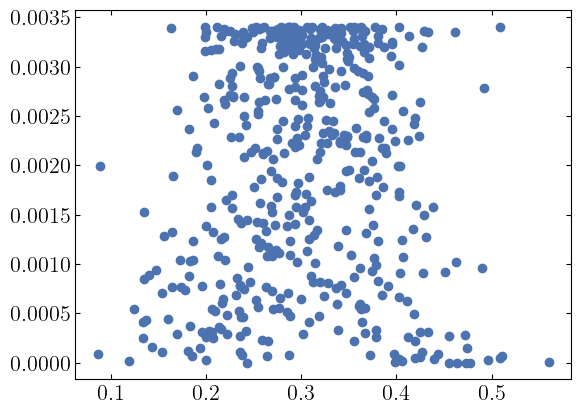

In [346]:
plt.plot(a_c,P_c,'o',label=f'$s = {s_nn:.3f}$')
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

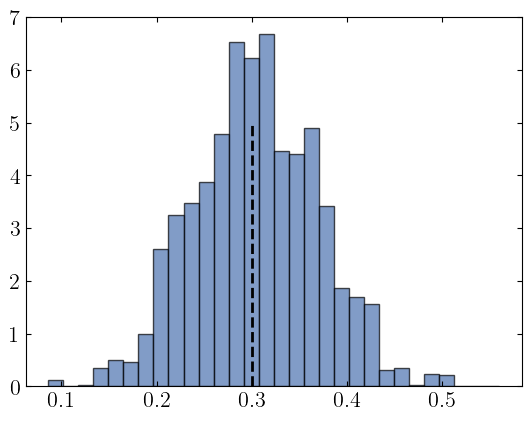

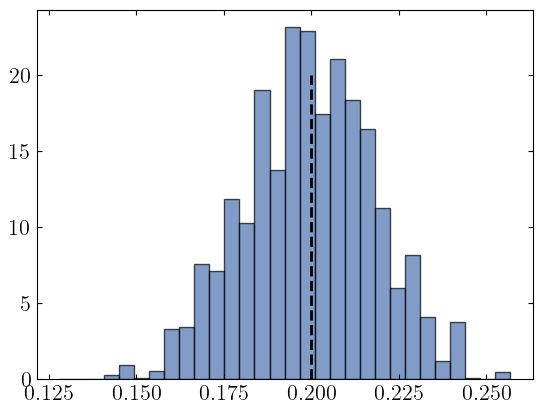

In [358]:
plt.hist(a_c,bins=30,weights=P_c,edgecolor='black', alpha=0.7,density=True)#,weights=P_§c,edgecolor='black', alpha=0.7)
plt.vlines(t_obs[0], 0, 5, color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
plt.show()
plt.hist(s_c,bins=30,weights=P_c,edgecolor='black', alpha=0.7,density=True)#,weights=P_§c,edgecolor='black', alpha=0.7)
plt.vlines(t_obs[1], 0, 20, color='black', lw=2, ls='--',label=f'$s = {t_obs[1]:.2f}$')
plt.show()